## Question 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn.externals import joblib
import time

%matplotlib inline

In this assignment, I am tasked to create a model which is able to guess the probability of default of a certain individual given the data about his previous loan behavior, demographic, financial conditions, etc. The probability will indicate the possibility of a person experiencing financial distress in the next two years

### Loading Dataset

In [2]:
df_data_dictionary = pd.read_excel('Data%20Dictionary.xls')
df_sample_entry = pd.read_csv('sampleEntry.csv')
df_train = pd.read_csv('cs-training.csv', index_col=0)
df_test = pd.read_csv('cs-test.csv', index_col=0)

In [3]:
pd.set_option('max_colwidth', -1)
display(df_data_dictionary)
pd.reset_option('max_colwidth')

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [4]:
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Train/Test Data Exploratory. 

First we want to know the dimension of the dataset

In [5]:
print df_train.shape
print df_test.shape

(150000, 11)
(101503, 11)


In [6]:
df_train.columns

Index([u'SeriousDlqin2yrs', u'RevolvingUtilizationOfUnsecuredLines', u'age',
       u'NumberOfTime30-59DaysPastDueNotWorse', u'DebtRatio', u'MonthlyIncome',
       u'NumberOfOpenCreditLinesAndLoans', u'NumberOfTimes90DaysLate',
       u'NumberRealEstateLoansOrLines',
       u'NumberOfTime60-89DaysPastDueNotWorse', u'NumberOfDependents'],
      dtype='object')

As the column names of the dataset is too long, I will create a dummy variable which stores the column names of the train & test dataset

In [7]:
DLQN = 'SeriousDlqin2yrs'
REVOLVE = 'RevolvingUtilizationOfUnsecuredLines'
AGE = 'age'
PASTDUE_30_59 = 'NumberOfTime30-59DaysPastDueNotWorse'
DEBT_RATIO = 'DebtRatio'
MONTHLY_INCOME = 'MonthlyIncome'
OPEN_CREDIT_LOAN = 'NumberOfOpenCreditLinesAndLoans'
PASTDUE_90 = 'NumberOfTimes90DaysLate'
ESTATE_LOAN = 'NumberRealEstateLoansOrLines'
PASTDUE_60_89 = 'NumberOfTime60-89DaysPastDueNotWorse'
DEPENDENTS = 'NumberOfDependents'

In [8]:
df_train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

A few notable observations:

- There are empty Values in the Monthly Income.
- There are empty Values in the Number of Dependents. 

Therefore, we need to decide how will we fill up this values / remove this observations

Then, we can try to find the proportion of the person who are experiencing the financial distress within 2 years in our training dataset. From the plot, we can see that the proportion of those people is relatively small in our dataset. Therefore, we could try to employ several techniques that help to make our model more robust against imbalanced datasets

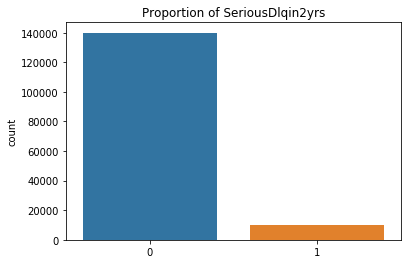

In [9]:
dlqn = df_train[DLQN].values
sns.countplot(dlqn).set_title('Proportion of ' + DLQN)
plt.show()

Next, we would like to explore the `RevolvingUtilizationOfUnsecuredLines` column. This is defined as the ratio of loan balance on credit cards and personal lines divided by the credit limits. Even though it is plausible to have a ratio bigger than 1., I am not entirely sure whether these values are outliers or not. Some values of `RevolvingUtilizationOfUnsecuredLines` within the train dataset is also extraordinarily large. 

In [20]:
revolve = df_train[REVOLVE]
print "Total RevolvingUtilizationOfUnsecuredLines :" \
+ str(len(revolve))
print "Total RevolvingUtilizationOfUnsecuredLines > 1.0 : "\
+ str(len(np.where(revolve > 1.0)[0]))
print "Total RevolvingUtilizationOfUnsecuredLines > 1.5 : "\
+ str(len(np.where(revolve > 1.5)[0]))
print "Total RevolvingUtilizationOfUnsecuredLines > 2.0 : "\
+ str(len(np.where(revolve > 2.0)[0]))
print "Total RevolvingUtilizationOfUnsecuredLines > 5.0 : "\
+ str(len(np.where(revolve > 5.0)[0]))
print "Total RevolvingUtilizationOfUnsecuredLines > 100.0 : "\
+ str(len(np.where(revolve > 100.0)[0]))

no_out_revolve = np.where(revolve > 1.0, 1.0, revolve)

Total RevolvingUtilizationOfUnsecuredLines :150000
Total RevolvingUtilizationOfUnsecuredLines > 1.0 : 3321
Total RevolvingUtilizationOfUnsecuredLines > 1.5 : 600
Total RevolvingUtilizationOfUnsecuredLines > 2.0 : 371
Total RevolvingUtilizationOfUnsecuredLines > 5.0 : 254
Total RevolvingUtilizationOfUnsecuredLines > 100.0 : 223


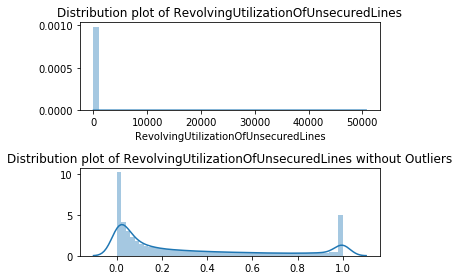

In [21]:
fig, axes = plt.subplots(nrows = 2)
sns.distplot(revolve, ax = axes[0]).\
set_title('Distribution plot of ' + REVOLVE)
sns.distplot(no_out_revolve, ax = axes[1]).\
set_title('Distribution plot of ' + REVOLVE + ' without Outliers')
plt.tight_layout()
plt.show()

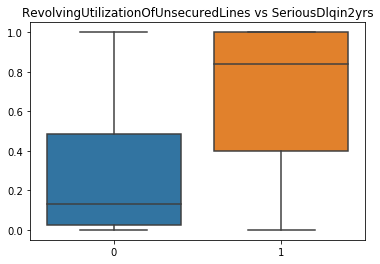

In [12]:
sns.boxplot(x = dlqn, y = no_out_revolve).set_title(REVOLVE  + ' vs ' + DLQN)
plt.show()

Next, we will check outlier values in the `Age` column. Most of the observations fall between 21 - 100, with the exception of few observations. As the number is very insignificant, we will force this values to be between 21 -100 as it will be hard for the model to learn about these features if the number of observation is too small

In [16]:
age = df_train[AGE].values
counter = Counter(age)
df_count =  pd.DataFrame.from_dict(counter, orient='index').reset_index()
df_count.columns = [AGE, 'total']
df_count[(df_count.age < 21 )| (df_count.age > 100)]

,age,total
0,0,1
80,101,3
81,102,3
82,103,3
83,105,1
84,107,1
85,109,2


In [17]:
no_out_age = np.where(age < 21, 21, age)
no_out_age = np.where(no_out_age > 100, 100, no_out_age)
counter = Counter(no_out_age)
df_count =  pd.DataFrame.from_dict(counter, orient='index').reset_index()
df_count.columns = [AGE, 'total']

Even though the difference distribution of the `age` between financially distressed and non financially distressed person is not as distinct as `RevolvingUtilizationOfUnsecuredLines`, it is still a good feature to predict the probability of financial distress.

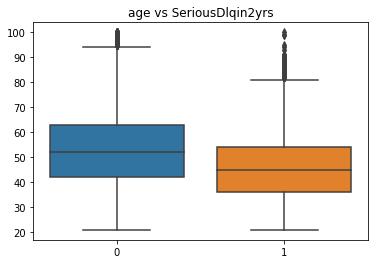

In [18]:
sns.boxplot(x = dlqn, y = no_out_age).set_title(AGE  + ' vs ' + DLQN)
plt.show()

Next, we will check The distribution of values for Past due 30-59, Past due 60 - 89, and Past due more than 90 days column. After displaying the distribution of values, we observe that there are a lot of observation with value 98 and 96. After checking the discussion forum on Kaggle, it is deduced that 98 and 96 is a code for indicating that there are no information available for the particular client. Thus, we need to transform those values into 0.

In [23]:
pastdue_30_59 = df_train[PASTDUE_30_59].values.astype(float)
pastdue_60_89 = df_train[PASTDUE_60_89].values.astype(float)
pastdue_90 = df_train[PASTDUE_90].values.astype(float)
df_30 =  pd.DataFrame.from_dict(Counter(pastdue_30_59),
                                orient='index').reset_index()
df_30.columns = ['number_pastdue', 'count_30']
df_60 = pd.DataFrame.from_dict(Counter(pastdue_60_89),
                               orient='index').reset_index()
df_60.columns = ['number_pastdue', 'count_60']
df_90 = pd.DataFrame.from_dict(Counter(pastdue_90), 
                               orient ='index').reset_index()
df_90.columns = ['number_pastdue', 'count_90']

list_df = [df_30, df_60, df_90]
df_final = \
reduce(lambda left,right: pd.merge(left,
                                   right,on='number_pastdue',
                                   how='outer'), list_df)
df_final = df_final.fillna(0.0)
display(df_final)

no_out_pastdue_30_59 = \
np.where(np.logical_or(pastdue_30_59 == 96. ,
                       pastdue_30_59 == 98.),
         0., pastdue_30_59)
no_out_pastdue_60_89 = \
np.where(np.logical_or(pastdue_60_89 == 96.,
                       pastdue_60_89 == 98.),
         0., pastdue_60_89)
no_out_pastdue_90 =\
np.where(np.logical_or(pastdue_90 == 96. ,
                       pastdue_90 == 98.),
         0., pastdue_90)

,number_pastdue,count_30,count_60,count_90
0,0.0,126018.0,142396.0,141662
1,1.0,16033.0,5731.0,5243
2,2.0,4598.0,1118.0,1555
3,3.0,1754.0,318.0,667
4,4.0,747.0,105.0,291
5,5.0,342.0,34.0,131
6,6.0,140.0,16.0,80
7,7.0,54.0,9.0,38
8,8.0,25.0,2.0,21
9,9.0,12.0,1.0,19


From the box plot below, we can see that most of the people who does not have financial distress in the next 2 years never had any bad debt at all. Thus, this is also a good feature to predict the probability of financial distress

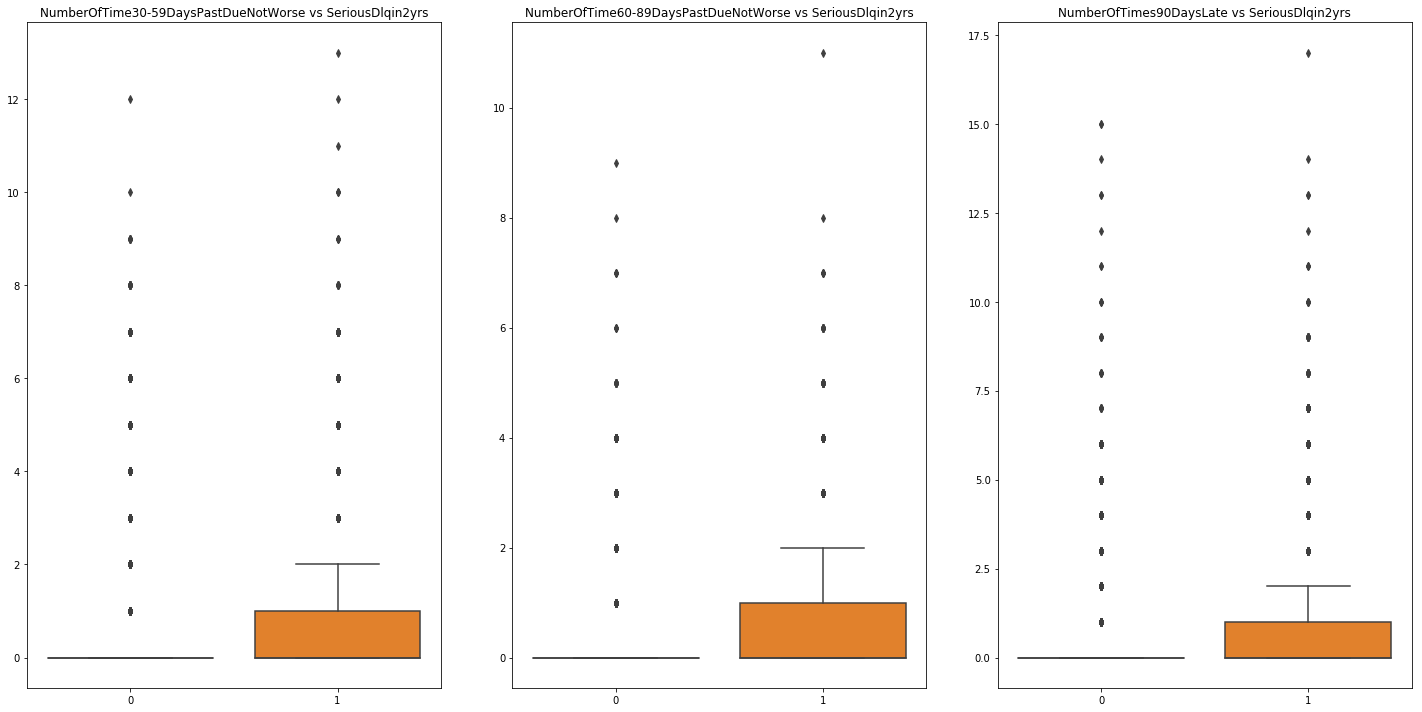

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
sns.boxplot(x = dlqn, 
            y = no_out_pastdue_30_59, ax=axes[0])\
.set_title(PASTDUE_30_59  + ' vs ' + DLQN)
sns.boxplot(x = dlqn, y = no_out_pastdue_60_89, ax=axes[1])\
.set_title(PASTDUE_60_89  + ' vs ' + DLQN)
sns.boxplot(x = dlqn, y = no_out_pastdue_90, ax=axes[2])\
.set_title(PASTDUE_90  + ' vs ' + DLQN)
plt.tight_layout()
plt.show()

Similar to `RevolvingUtilizationOfUnsecuredLines`, few observations of `monthly_income` is particularly high compared to the rest of the values. Therefore, we need to put a higher boundary in the `monthly_income` value. After looking at the data, we decide to put the higher boundary at 20000.0

In [34]:
monthly_income = df_train[MONTHLY_INCOME]
monthly_income = np.where(pd.isnull(monthly_income),
                          np.nanmedian(monthly_income),
                          monthly_income)
print "Total monthly_income :" + str(len(monthly_income))
print "Total monthly_income > 1000.0 : " +\
str(len(np.where(monthly_income > 1000.0)[0]))
print "Total monthly_income > 10000.0 : " +\
str(len(np.where(monthly_income > 10000.0)[0]))
print "Total monthly_income > 20000.0 : " + \
str(len(np.where(monthly_income > 20000.0)[0]))
print "Total monthly_income > 50000.0 : " + \
str(len(np.where(monthly_income > 50000.0)[0]))
print "Total monthly_income > 100000.0 : " +\
str(len(np.where(monthly_income > 100000.0)[0]))
no_out_monthly_income = np.where(monthly_income > 20000.0,
                                 np.nanmedian(monthly_income), 
                                 monthly_income)

Total monthly_income :150000
Total monthly_income > 1000.0 : 145205
Total monthly_income > 10000.0 : 18319
Total monthly_income > 20000.0 : 2103
Total monthly_income > 50000.0 : 301
Total monthly_income > 100000.0 : 70


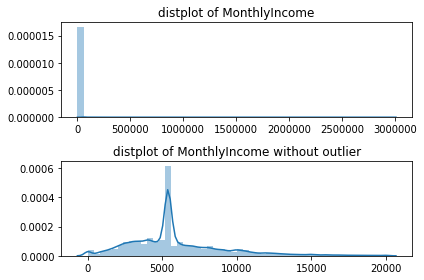

In [27]:
fig, axes = plt.subplots(nrows = 2)
sns.distplot(monthly_income, ax = axes[0]).\
set_title('distplot of ' + str(MONTHLY_INCOME))
sns.distplot(no_out_monthly_income).\
set_title('distplot of ' + str(MONTHLY_INCOME) + ' without outlier')
plt.tight_layout()
plt.show()

We will also remove all outlier values under `DebtRatio` column

In [28]:
debtratio = df_train[DEBT_RATIO].values
print "Total debtratio :" + str(len(debtratio))
print "Total debtratio > 100.0 : " +\
str(len(np.where(debtratio > 100.0)[0]))
print "Total debtratio > 1000.0 : " +\
str(len(np.where(debtratio > 1000.0)[0]))
print "Total debtratio > 5000.0 : " + \
str(len(np.where(debtratio > 5000.0)[0]))
print "Total debtratio > 10000.0 : " + \
str(len(np.where(debtratio > 10000.0)[0]))

Total debtratio :150000
Total debtratio > 100.0 : 24380
Total debtratio > 1000.0 : 16892
Total debtratio > 5000.0 : 1481
Total debtratio > 10000.0 : 180


In [29]:
no_out_ratio = np.where(debtratio > 5000.0, 5000.0, debtratio)

The distribution of the values for `NumberOfOpenCreditLinesAndLoans`, `NumberRealEstateLoansOrLines`, and `NumberOfDependents` looks reasonable. Therefore, we do not perform any modification to these values.

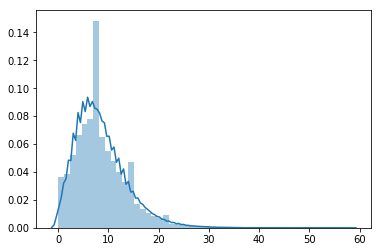

In [30]:
open_credit_loan = df_train[OPEN_CREDIT_LOAN].values
sns.distplot(open_credit_loan)

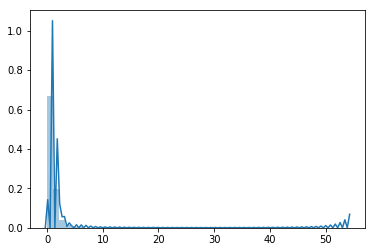

In [31]:
real_estate_loan = df_train[ESTATE_LOAN].values
sns.distplot(real_estate_loan)

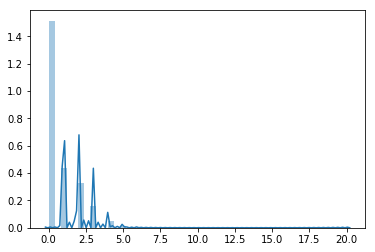

In [32]:
dependents = df_train[DEPENDENTS].values
dependents = np.where(pd.isnull(dependents), 0.0, dependents)
sns.distplot(dependents)

We perform the transformation of all the outlier values as well as fill up all missing values according to the rules that we have set during the exploration stage, using the `prepare_dataset` function. we will use this functions to transform our data in both train and test dataset

In [39]:
def prepare_dataset(df_train):
    revolve = df_train[REVOLVE]
    age = df_train[AGE].values
    pastdue_30_59 = df_train[PASTDUE_30_59].values.astype(float)
    pastdue_60_89 = df_train[PASTDUE_60_89].values.astype(float)
    pastdue_90 = df_train[PASTDUE_90].values.astype(float)
    monthly_income = df_train[MONTHLY_INCOME]
    monthly_income = np.where(pd.isnull(monthly_income), np.nanmedian(monthly_income), monthly_income)
    dependents = df_train[DEPENDENTS].values
    debtratio = df_train[DEBT_RATIO].values
    
    no_out_revolve = np.where(revolve > 1.0, 1.0, revolve)
    no_out_age = np.where(age < 21, 21, age)
    no_out_age = np.where(no_out_age > 100, 100, no_out_age)
    no_out_pastdue_30_59 = \
    np.where(np.logical_or(pastdue_30_59 == 96. ,
                           pastdue_30_59 == 98.), 0., pastdue_30_59)
    no_out_pastdue_60_89 =\
    np.where(np.logical_or(pastdue_60_89 == 96.,
                           pastdue_60_89 == 98.), 0., pastdue_60_89)
    no_out_pastdue_90 = \
    np.where(np.logical_or(pastdue_90 == 96. ,
                           pastdue_90 == 98.), 0., pastdue_90)
    no_out_monthly_income =\
    np.where(monthly_income > 20000.0,
             np.nanmedian(monthly_income), monthly_income)
    no_out_dependents = \
    np.where(pd.isnull(dependents), 0.0, dependents)
    no_out_ratio = np.where(debtratio > 5000.0, 5000.0, debtratio)
    
    df_train[REVOLVE] = no_out_revolve.astype(float)
    df_train[AGE] = no_out_age.astype(int)
    df_train[PASTDUE_30_59] = no_out_pastdue_30_59.astype(int)
    df_train[PASTDUE_60_89] = no_out_pastdue_60_89.astype(int)
    df_train[PASTDUE_90] = no_out_pastdue_90.astype(int)
    df_train[MONTHLY_INCOME] = no_out_monthly_income.astype(float)
    df_train[DEPENDENTS] = no_out_dependents.astype(int)
    df_train[DEBT_RATIO] = no_out_ratio.astype(float)
    
    x_train = df_train[[u'RevolvingUtilizationOfUnsecuredLines', 
                        u'age',
       u'NumberOfTime30-59DaysPastDueNotWorse', u'DebtRatio',
                        u'MonthlyIncome',
       u'NumberOfOpenCreditLinesAndLoans', 
                        u'NumberOfTimes90DaysLate',
       u'NumberRealEstateLoansOrLines',
       u'NumberOfTime60-89DaysPastDueNotWorse',
                        u'NumberOfDependents']].values
    y_train = df_train['SeriousDlqin2yrs'].values
    
    return x_train, y_train

## Model

We can then perform the split within the full training dataset to have validation data. This validation data will be used to measure the accuracy of the predicted probability.

In [40]:
full_X_train, full_y_train = prepare_dataset(df_train)

In [41]:
X_test, y_test = prepare_dataset(df_test)

In [42]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss

In [43]:
X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size = 0.20)

The model that we use in this case is ensemble model between Logistic Regression, Random Forest, and Gradient Boosting Classifier. As we are trying to predict the probability of financial distress in each model, we are able to take the weighted average between each model as our final prediction.

- For the Logistic Regression Model, I use `LogisticRegressionCV` function from the `sklearn` package that automatically perform cross validation for different Logistic Regression Model with different values of regularization and automatically chooses the model which minimizes the loss of the CV. 

- We will also try to fit Gradient Boosting and Random Forest Model. The values for the parameters intially choosed based on my initial guess.

In [44]:
lr_CV_model = LogisticRegressionCV()
lr_CV_model.fit(X_train, y_train)
lrm_prob = lr_CV_model.predict_proba(X_val)

In [ ]:
gb_model = GradientBoostingClassifier(loss='deviance', 
                                      learning_rate=0.02, 
                                      n_estimators=500, 
                                      subsample=1.0,
                                   min_samples_split= 0.005, 
                                      min_samples_leaf= 0.005,
                                      max_depth=15,
                                   init=None, random_state=None,
                                      max_features= 0.2, verbose=1)
gb_model.fit(X_train, y_train)
gb_prob = gb_model.predict_proba(X_val)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=500, 
                                  criterion='gini', 
                                  max_depth=3,
                                  min_samples_split=7,
                               min_samples_leaf= 5,
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=7,
                               max_leaf_nodes=None,
                                  bootstrap=True, 
                                  verbose=1)
rf_model.fit(X_train, y_train)
rf_prob = rf_model.predict_proba(X_val)

Looking at the result, we can see that the three model perform relatively well in our validation dataset. We will do this by comparing the negative log loss between the predicted probability of the validation dataset using each model against the true value of the validation dataset

In [48]:
print log_loss(y_val, lrm_prob)
print log_loss(y_val, gb_prob)
print log_loss(y_val, rf_prob)

0.19585695055327748
0.1819052662602875
0.1915520631753691


After ensuring that the three probability works relatively well, we will then fit the full training dataset in our model. We will also perform hyperparameter tuning for our Random Forest Model as well as Gradient Boosting Model. We will use `RandomizedSearchCV`, which allows us to randomly choose set of parameters from the parameter space that we have identified. We will then perform cross validation using the randomly chosen parameter, and calculate the mean negative log loss value. The model will choose the set of parameters which minimizes this Cross Validation value

In [49]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [ ]:
rf_params = {"max_depth": [3, 5, 7, 9 ,12, 15, 25, None],
              "max_features": [0.1, 0.2, 0.3,
                               'sqrt', 0.5 , None],
              "n_estimators":[500],
              "min_samples_leaf": [2 ,5, 10, 25, 50, 100]\
             + np.arange(0.001, 0.01, 0.001).tolist(),
              "min_samples_split": [2 ,5, 10, 25, 50, 100] \
             + np.arange(0.001, 0.01, 0.001).tolist(),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
            }


In [ ]:
rf_CV_model = \
RandomizedSearchCV(estimator=rf_model, 
                   param_distributions=rf_params,
                   n_iter= 300,
                   scoring='neg_log_loss',
                   cv=3, verbose= 2,
                   n_jobs = -1,
                   return_train_score = True)\
.fit(full_X_train, full_y_train)

In [ ]:
joblib.dump(rf_CV_model, 'rf_CV_model.pkl') 

In [ ]:
def get_parameter_space(param_dict):
    space = 1
    for key in param_dict.keys():
        space = space * len(param_dict[key])
    return space

get_parameter_space(gb_params)

In [ ]:
gb_params = {
    'learning_rate' : np.arange(0.01, 0.10, 0.01),
    'max_depth' : np.arange(3, 25, 2),
    "max_features" : [0.1, 0.3, 0.5, 'auto', 'log2', None],
    'subsample' : [1.0],
    'n_estimators' : [100],
    "min_samples_leaf": [2 ,5, 10, 25, 50, 100] \
    + np.arange(0.001, 0.01, 0.001).tolist(),
    "min_samples_split": [2 ,5, 10, 25, 50, 100]\
    + np.arange(0.001, 0.01, 0.001).tolist(),
}

In [ ]:
gb_CV_model = \
RandomizedSearchCV(estimator=gb_model,
                   param_distributions=gb_params,
                   n_iter= 500, scoring='neg_log_loss', 
                   cv=3, verbose=1, n_jobs = -1, 
                   return_train_score = True)\
.fit(full_X_train, full_y_train)

In [ ]:
joblib.dump(gb_CV_model, 'gb_CV_model.pkl') 

In [50]:
rf_CV_model = joblib.load('rf_CV_model.pkl')
gb_CV_model = joblib.load('gb_CV_model.pkl')

As we can see from the values of the cross validation results, the best parameters for the Gradient Boosting model have relatively high `max_depth` value, indicating that we are able to fit complex model as we have high-dimension, high-observation dataset. One point to note is that the number of estimators used in this model might be lacking. Similarly, the Parameters chosen for the Random Forest model is shown below.

In [53]:
report(gb_CV_model.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: -0.178 (std: 0.001)
Parameters: {'subsample': 1.0, 'learning_rate': 0.05, 'min_samples_leaf': 0.005, 'n_estimators': 100, 'min_samples_split': 0.008, 'max_features': 0.3, 'max_depth': 11}

Model with rank: 2
Mean validation score: -0.178 (std: 0.001)
Parameters: {'subsample': 1.0, 'learning_rate': 0.06999999999999999, 'min_samples_leaf': 0.004, 'n_estimators': 100, 'min_samples_split': 0.003, 'max_features': 0.5, 'max_depth': 7}

Model with rank: 3
Mean validation score: -0.178 (std: 0.001)
Parameters: {'subsample': 1.0, 'learning_rate': 0.060000000000000005, 'min_samples_leaf': 0.005, 'n_estimators': 100, 'min_samples_split': 0.006, 'max_features': 0.3, 'max_depth': 11}



In [52]:
report(rf_CV_model.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: -0.179 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 500, 'min_samples_split': 25, 'criterion': 'gini', 'max_features': 0.2, 'max_depth': 15}

Model with rank: 2
Mean validation score: -0.179 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 500, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 0.3, 'max_depth': 12}

Model with rank: 3
Mean validation score: -0.179 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 500, 'min_samples_split': 0.001, 'criterion': 'gini', 'max_features': 0.2, 'max_depth': 12}



We can then combine the probability prediction for the Logistic Regression, Random Forest, and Gradient Boosting weighted by their relative performance in the validation dataset to get our final prediction

In [54]:
def ensemble_prob_predict(lr_CV_model,
                          rf_CV_model, gb_CV_model, 
                          X_test):
    lr_proba=  lr_CV_model.predict_proba(X_test)
    rf_proba = rf_CV_model.predict_proba(X_test)
    gb_proba = gb_CV_model.predict_proba(X_test)
    return 0.1 * lr_proba + 0.45 * rf_proba \
+ 0.45 * gb_proba

In [55]:
y_test_proba = ensemble_prob_predict(lr_CV_model,
                                     rf_CV_model, 
                                     gb_CV_model, 
                                     X_test)

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    8.3s finished


In [56]:
y_test_proba.shape

(101503, 2)

In [ ]:
dict_pred = {
    'Id' : range(1, 101504),
    'Probability' : y_test_proba[:,1]
}

df_pred = pd.DataFrame(dict_pred)

In [ ]:
df_pred.to_csv('entry.csv', index=False)